In [1]:
import numpy as np
import scipy as sp
import h5py
import matplotlib.pyplot as plt

from skimage import transform

from keras.models import Sequential, Model, load_model
from keras.layers import (Activation, Conv2D, ReLU, MaxPooling2D, \
                          Conv2DTranspose, Dropout, Input, Concatenate)
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
PATH = '/home/maldonado/Machine/data/brain/'
imgurls = !ls '{PATH}'

In [3]:
n = len(imgurls)
ntr = int(0.8 * n)

train_urls = imgurls[:ntr]
test_urls = imgurls[ntr:n]

In [4]:
# Parameters
img_width = 128
img_heigth = 128
img_channel = 3

In [5]:
x_train = np.zeros((len(train_urls), img_heigth, img_width, img_channel))
y_train = np.zeros((len(train_urls), img_heigth, img_width, 1), dtype=np.bool)

x_test = np.zeros((len(test_urls), img_heigth, img_width, img_channel))
y_test = np.zeros((len(test_urls), img_heigth, img_width, 1), dtype=np.bool)

print(x_train.shape)
print(y_train.shape)

(320, 128, 128, 3)
(320, 128, 128, 1)


In [6]:
def read_files(files, xt, yt):
    
    for idx, file in enumerate(files):
        mat = h5py.File(PATH + file, 'r')        
        
        img = transform.resize(mat.get('cjdata').get('image'), (img_heigth, img_width))
        tma = transform.resize(mat.get('cjdata').get('tumorMask'), (img_heigth, img_width))

        xt[idx] = img[:,:,np.newaxis]
        yt[idx] = tma[:,:,np.newaxis]
        
read_files(train_urls, x_train, y_train)
read_files(test_urls, x_test, y_test)

In [7]:
def plot_img(xtr, ytr):
    plt.subplot(121)
    plt.imshow(xtr, cmap='gray')

    plt.subplot(122)
    plt.imshow(ytr, cmap='gray')

    plt.show()

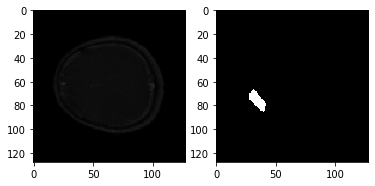

In [8]:
nr = np.random.randint(len(x_train))
plot_img(x_train[nr,:,:], y_train[nr,:,:,0])

In [9]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
        
    return K.mean(K.stack(prec), axis=0)

In [10]:
# Block Code
def block(filters, b):
    # Convolution Layer
    c = Conv2D(filters, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(b)
        
    # Dropout Layer
    c = Dropout(0.1)(c)
        
    # Convolution Layer
    c = Conv2D(filters, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c)
    
    return c

In [11]:
# Generator Network
def unet():    
    inputs = Input(shape=[img_heigth, img_heigth, img_channel])
    
    c1 = block(16, inputs)
    p1 = MaxPooling2D()(c1)
    
    c2 = block(32, p1)
    p2 = MaxPooling2D()(c2)
    
    c3 = block(64, p2)
    p3 = MaxPooling2D()(c3)
    
    c4 = block(128, p3)
    p4 = MaxPooling2D()(c4)
    
    c5 = block(256, p4)
    
    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = Concatenate()([u6,c4])
    c6 = block(128, u6)
    
    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = Concatenate()([u7,c3])
    c7 = block(64, u7)
    
    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = Concatenate()([u8,c2])
    c8 = block(32, u8)
    
    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = Concatenate()([u9,c1])
    c9 = block(16, u9)
    
    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [12]:
un = unet()
un.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
un.summary()


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
___________________________________________________________________

In [13]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('../data/model.h5', verbose=1, save_best_only=True)

results = un.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])


Train on 288 samples, validate on 32 samples
Epoch 1/50
288/288 [==============================] - 33s 115ms/step - loss: 0.2501 - mean_iou: 0.4480 - val_loss: 0.1405 - val_mean_iou: 0.4833

Epoch 00001: val_loss improved from inf to 0.14052, saving model to ../data/model.h5
Epoch 2/50
288/288 [==============================] - 31s 107ms/step - loss: 0.0776 - mean_iou: 0.4878 - val_loss: 0.1222 - val_mean_iou: 0.4904

Epoch 00002: val_loss improved from 0.14052 to 0.12224, saving model to ../data/model.h5
Epoch 3/50
288/288 [==============================] - 34s 119ms/step - loss: 0.0613 - mean_iou: 0.4915 - val_loss: 0.1065 - val_mean_iou: 0.4923

Epoch 00003: val_loss improved from 0.12224 to 0.10654, saving model to ../data/model.h5
Epoch 4/50
288/288 [==============================] - 44s 153ms/step - loss: 0.0569 - mean_iou: 0.4927 - val_loss: 0.1361 - val_mean_iou: 0.4930

Epoch 00004: val_loss did not improve from 0.10654
Epoch 5/50
288/288 [==============================] - 40

In [14]:
print(results.history['val_loss'])
print(results.history['val_mean_iou'])
print(results.history['loss'])
print(results.history['mean_iou'])

[0.14052464812994003, 0.12223782017827034, 0.10654497146606445, 0.1361057013273239, 0.13153418898582458, 0.08837264031171799, 0.10286560282111168, 0.08084146678447723, 0.09395177662372589, 0.08753795921802521, 0.09033962897956371, 0.10284292325377464, 0.09137681499123573]
[0.4833352267742157, 0.4904347062110901, 0.49225562810897827, 0.4929850697517395, 0.49333661794662476, 0.49352601170539856, 0.4936349093914032, 0.4937000274658203, 0.4937395751476288, 0.49376362562179565, 0.493777871131897, 0.4937857389450073, 0.4937893748283386]
[0.25008749465147656, 0.07759130001068115, 0.061328132119443685, 0.05688512677119838, 0.0521601467496819, 0.05129236376119985, 0.04838117563890086, 0.04756065602931711, 0.05044813495543268, 0.04666031669411394, 0.046234886886345014, 0.04493240422258774, 0.0441060538093249]
[0.44803804, 0.48781574, 0.49151325, 0.49266657, 0.4931321, 0.4934033, 0.49360582, 0.4936584, 0.49370256, 0.49375078, 0.49374306, 0.4937625, 0.49379158]


In [15]:
#un = load_model('../data/model.h5', custom_objects={'mean_iou': mean_iou})
preds_train = un.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
preds_val   = un.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test  = un.predict(x_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

80/80 [==============================] - 2s 30ms/step


In [20]:
print(preds_train.max())
print(preds_train.min())

print(x_train[0].max())
print(x_train[0].max())

0.27205384
0.0
0.12605477988861
0.12605477988861


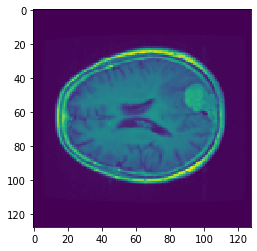

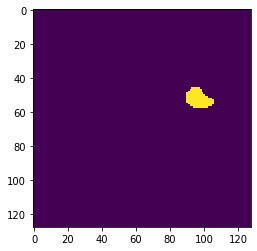

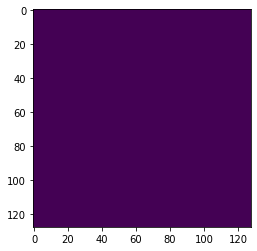

In [16]:
ix = np.random.randint(0, len(preds_train_t))

plt.imshow(x_train[ix][:,:,0])
plt.show()

plt.imshow(np.squeeze(y_train[ix]))
plt.show()

plt.imshow(np.squeeze(preds_train_t[ix][:,:,0]))
plt.show()